# Classification de Produits Rakuten

**Objectif du projet :** Ce notebook a pour but de développer et d'évaluer un pipeline de Machine Learning capable de classifier automatiquement des produits du catalogue Rakuten en se basant sur leurs descriptions textuelles.

**Démarche :**
Nous allons suivre une méthodologie structurée, partant des données brutes pour arriver à un modèle optimisé et interprétable.
1.  **Configuration** de l'environnement et importation des bibliothèques.
2.  **Chargement et Exploration** des données fournies.
3.  **Prétraitement et Nettoyage** du texte pour le rendre exploitable.
4.  **Vectorisation** pour convertir le texte en données numériques.
5.  **Modélisation** et comparaison de plusieurs algorithmes classiques (SVM, Naive Bayes, etc.).
6.  **Optimisation** du meilleur modèle via la recherche d'hyperparamètres.
7.  **Exploration** de modèles de Deep Learning (CNN, CamemBERT) pour évaluer leur potentiel.

**Installation des dépendances**

Nous commençons par installer la bibliothèque `langid`, qui est essentielle pour notre étape de détection de la langue.

In [ ]:
!pip install langid -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


**Configuration de l'Environnement**

Cette première section est dédiée à l'importation de toutes les bibliothèques nécessaires pour notre analyse. Elles sont organisées par fonctionnalité pour plus de clarté.

In [ ]:
# ====== 1. INITIALISATION ET IMPORTATIONS ======

# Bibliothèques standard
import os
import re
import string
import html
from joblib import load, dump

# Manipulation de données et visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement du texte et NLP (Natural Language Processing)
from bs4 import BeautifulSoup
import langid

# Machine Learning (Scikit-learn)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Importations nécessaires pour TensorFlow/Keras ---
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Montage de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Chargement et Préparation des Données**

Nous chargeons les jeux de données d'entraînement `X_train.csv` et `Y_train.csv` depuis Google Drive.

**Étapes clés :**
- Fusionner les features (descriptions) et les labels (catégories) en un seul DataFrame.
- Combiner les colonnes `designation` et `description` en une seule colonne de texte (`text_product`) pour maximiser la quantité d'information textuelle disponible pour chaque produit.
- Supprimer les colonnes inutiles pour alléger notre DataFrame.

In [ ]:
# ====== 2. CHARGEMENT ET PRÉPARATION INITIALE DES DONNÉES ======

# Chargement des données d'entraînement depuis Google Drive
try:
    x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_rakuten/X_train.csv", index_col=0)
    y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data_rakuten/Y_train.csv", index_col=0)
    df = x_train.join(y_train, how='inner')
    print("Données chargées et fusionnées avec succès.")
except FileNotFoundError:
    print("ERREUR : Fichiers X_train.csv ou Y_train.csv non trouvés. Vérifiez le chemin.")
    df = pd.DataFrame() # Crée un dataframe vide pour éviter les erreurs suivantes

if not df.empty:
    # Création d'une colonne unique combinant la désignation et la description
    df["text_product"] = df[["designation", "description"]].fillna("").agg(" ".join, axis=1)

    # Suppression des colonnes devenues inutiles
    df.drop(columns=["designation", "description", "imageid", "productid"], inplace=True)
    df.info()

Données chargées et fusionnées avec succès.
<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prdtypecode   84916 non-null  int64 
 1   text_product  84916 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


**Chargement et Préparation des Données**

Nous chargeons les jeux de données d'entraînement `X_train.csv` et `Y_train.csv` depuis Google Drive.

**Étapes clés :**
- Fusionner les features (descriptions) et les labels (catégories) en un seul DataFrame.
- Combiner les colonnes `designation` et `description` en une seule colonne de texte (`text_product`) pour maximiser la quantité d'information textuelle disponible pour chaque produit.
- Supprimer les colonnes inutiles pour alléger notre DataFrame.

In [ ]:
# ====== 3. NETTOYAGE ET FILTRAGE DU TEXTE ======

def clean_html_and_normalize(text):
    """
    Nettoie le texte en retirant les balises HTML, en décodant les entités HTML,
    et en normalisant les espaces et la casse.

    Args:
        text (str): Le texte brut à nettoyer.

    Returns:
        str: Le texte nettoyé.
    """
    if not isinstance(text, str):
        return ""
    # Décodage des entités HTML (ex: &amp; -> &)
    text = html.unescape(text)
    # Suppression de toutes les balises HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remplacement des espaces multiples par un seul et mise en minuscules
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

def detect_language(text):
    """Détecte la langue d'un texte en utilisant langid."""
    try:
        return langid.classify(text)[0]
    except Exception:
        return "unknown"

def remove_punctuation_and_digits(text):
    """Supprime la ponctuation et les chiffres d'un texte."""
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

if not df.empty:
    # --- 3.1. Nettoyage HTML et Normalisation ---
    df['text_product_clean'] = df['text_product'].apply(clean_html_and_normalize)

    # --- 3.2. Détection et Filtrage de la Langue ---
    print("\nDétection de la langue en cours...")
    df['lang'] = df['text_product_clean'].apply(detect_language)
    print("Langues détectées (top 5) :\n", df['lang'].value_counts().head())

    df_fr = df[df['lang'] == 'fr'].copy()
    print(f"\nDonnées filtrées pour ne garder que le français. Taille restante : {len(df_fr)}/{len(df)}")

    # --- 3.3. Nettoyage Final (Ponctuation et Chiffres) ---
    df_fr["cleaned_text"] = df_fr["text_product_clean"].apply(remove_punctuation_and_digits)

    print("\nAperçu des données après nettoyage complet :")
    display(df_fr[['cleaned_text', 'prdtypecode']].head())


Détection de la langue en cours...
Langues détectées (top 5) :
 lang
fr    70469
en     8289
it      741
es      669
de      668
Name: count, dtype: int64

Données filtrées pour ne garder que le français. Taille restante : 70469/84916

Aperçu des données après nettoyage complet :


,cleaned_text,prdtypecode
1,journal des arts le n° du lart et son marche s...,2280
2,grand stylet ergonomique bleu gamepad nintendo...,50
3,peluche donald europe disneyland marionnette à...,1280
4,la guerre des tuques luc a des idées de grande...,2705
5,afrique contemporaine n° hiver dossier japon a...,2280


Sauvegarde des Données Nettoyées

Pour optimiser notre flux de travail et éviter de répéter ces étapes de nettoyage à chaque session, nous sauvegardons le DataFrame nettoyé et filtré.

In [ ]:
# ====== 3bis. SAUVEGARDE DU DATAFRAME NETTOYÉ ======

# Nous sauvegardons le dataframe nettoyé et filtré pour la langue française.
# Cela nous permettra de reprendre le travail directement avant la séparation
# des données si nous souhaitons la modifier.

# Définir le chemin de sauvegarde (le même que pour les autres fichiers)
save_path = "/content/drive/MyDrive/Colab Notebooks/data_rakuten/preprocessed/"
os.makedirs(save_path, exist_ok=True)

# --- Sauvegarde du DataFrame df_fr ---
df_fr.to_csv(os.path.join(save_path, "df_fr_cleaned.csv"), index=False)
print(f"DataFrame 'df_fr' sauvegardé avec succès au format CSV : {os.path.join(save_path, 'df_fr_cleaned.csv')}")

DataFrame 'df_fr' sauvegardé avec succès au format CSV : /content/drive/MyDrive/Colab Notebooks/data_rakuten/preprocessed/df_fr_cleaned.csv


**Encodage des Labels et Séparation des Données**

Avant d'entraîner nos modèles, deux étapes sont indispensables : l'encodage des catégories de produits et la division de nos données en ensembles d'entraînement et de test.

**Encodage avec `LabelEncoder`**

Les algorithmes de Machine Learning travaillent avec des nombres, pas avec des étiquettes textuelles. `LabelEncoder` convertit chaque code de catégorie produit (`prdtypecode`) en un entier unique (0, 1, 2, ...). C'est une étape simple et rapide, parfaitement adaptée pour les labels de classification.

**Séparation des Données (`train_test_split`)**

C'est une étape critique qui doit impérativement être réalisée **avant** la vectorisation pour une raison fondamentale :

> **Éviter la fuite de données (Data Leakage)** : Si nous vectorisions l'ensemble des données avant de les diviser, le vectoriseur (par exemple, `TfidfVectorizer`) apprendrait le vocabulaire complet, y compris celui de l'ensemble de test. Le modèle serait alors entraîné sur des informations qu'il ne devrait pas connaître, menant à une évaluation artificiellement optimiste et non représentative de ses performances en conditions réelles.

Nous utilisons une répartition stratifiée (`stratify=y`) pour nous assurer que la proportion de chaque catégorie de produit est la même dans l'ensemble d'entraînement et de test.

In [ ]:
# ====== 4. ENCODAGE DES LABELS ET SÉPARATION DES DONNÉES ======

if not df_fr.empty:
    # Encodage de la variable cible textuelle en numérique
    label_encoder = LabelEncoder()
    df_fr["label_encoded"] = label_encoder.fit_transform(df_fr["prdtypecode"])

    # Séparation des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        df_fr["cleaned_text"],
        df_fr["label_encoded"],
        test_size=0.2,
        random_state=42,
        stratify=df_fr["label_encoded"] # Assure une répartition équilibrée des classes
    )
    print(f"\nDonnées séparées en {len(X_train)} pour l'entraînement et {len(X_test)} pour le test.")


Données séparées en 56375 pour l'entraînement et 14094 pour le test.


In [ ]:
# ====== 4bis. SAUVEGARDE DES DONNÉES PRÉTRAITÉES ======

# Pour éviter de ré-exécuter toutes les étapes de nettoyage à chaque session,
# nous sauvegardons les jeux de données d'entraînement et de test, ainsi que
# l'encodeur de labels qui contient le mappage des classes.

print("--- Sauvegarde des données prétraitées ---")

# Définir le chemin de sauvegarde dans votre Google Drive
save_path = "/content/drive/MyDrive/Colab Notebooks/data_rakuten/preprocessed/"

# Créer le dossier s'il n'existe pas
os.makedirs(save_path, exist_ok=True)
print(f"Dossier de sauvegarde : {save_path}")

# Sauvegarder les dataframes/séries en format CSV
X_train.to_csv(os.path.join(save_path, "X_train_preprocessed.csv"), index=False)
X_test.to_csv(os.path.join(save_path, "X_test_preprocessed.csv"), index=False)
y_train.to_csv(os.path.join(save_path, "y_train_encoded.csv"), index=False)
y_test.to_csv(os.path.join(save_path, "y_test_encoded.csv"), index=False)

print("Jeux de données X_train, X_test, y_train, y_test sauvegardés.")

# Sauvegarder l'objet LabelEncoder avec joblib (recommandé pour les objets scikit-learn)
dump(label_encoder, os.path.join(save_path, 'label_encoder.joblib'))
print("LabelEncoder sauvegardé.")

print("\nSauvegarde terminée. Vous pouvez maintenant utiliser le notebook de chargement rapide.")

--- Sauvegarde des données prétraitées ---
Dossier de sauvegarde : /content/drive/MyDrive/Colab Notebooks/data_rakuten/preprocessed/
Jeux de données X_train, X_test, y_train, y_test sauvegardés.
LabelEncoder sauvegardé.

Sauvegarde terminée. Vous pouvez maintenant utiliser le notebook de chargement rapide.


**Point de Reprise : Chargement Rapide des Données**

La cellule de code suivante est un point de chargement intelligent. Elle permet de reprendre le notebook directement après les étapes de prétraitement et de séparation, sans avoir à tout ré-exécuter.

In [ ]:
# ====== CHARGEMENT RAPIDE ET INTELLIGENT DES DONNÉES ======
#
# Cette cellule remplace les étapes 2, 3, et potentiellement 4.
# Elle cherche d'abord les données les plus avancées (déjà séparées).
# Si elles n'existent pas, elle charge le dataframe nettoyé d'avant la séparation.
# Faire attention aux messages de sortie qui indique la prochaine étape à suivre.

print("--- Lancement du chargement rapide et intelligent ---")

# Définir les chemins de sauvegarde
save_path = "/content/drive/MyDrive/Colab Notebooks/data_rakuten/preprocessed/"

# Noms des fichiers attendus
df_fr_path = os.path.join(save_path, "df_fr_cleaned.pkl")
x_train_path = os.path.join(save_path, "X_train_preprocessed.csv")
encoder_path = os.path.join(save_path, 'label_encoder.joblib')

# --- Logique de chargement ---

# OPTION 1 : Tenter de charger les données déjà séparées (le plus rapide)
if os.path.exists(x_train_path) and os.path.exists(encoder_path):
    print("Fichiers des données séparées trouvés. Chargement en cours...")

    X_train = pd.read_csv(os.path.join(save_path, "X_train_preprocessed.csv")).squeeze("columns")
    X_test = pd.read_csv(os.path.join(save_path, "X_test_preprocessed.csv")).squeeze("columns")
    y_train = pd.read_csv(os.path.join(save_path, "y_train_encoded.csv")).squeeze("columns")
    y_test = pd.read_csv(os.path.join(save_path, "y_test_encoded.csv")).squeeze("columns")
    label_encoder = load(encoder_path)

    print("Chargement des données séparées terminé.")
    print(f"Taille de X_train : {len(X_train)}")
    print("\n>>> Vous pouvez passer directement à l'Étape 5.")

# OPTION 2 : Sinon, tenter de charger le dataframe nettoyé (avant séparation)
elif os.path.exists(df_fr_path):
    print("Données séparées non trouvées. Chargement du dataframe nettoyé 'df_fr'...")

    df_fr = pd.read_pickle(df_fr_path)
    print("Chargement du DataFrame 'df_fr' terminé.")
    display(df_fr.head())

    print("\n**********************************************************************************")
    print(">>> ACTION REQUISE : Exécutez maintenant la cellule de l'Étape 4 (train_test_split)")
    print(">>> pour générer les variables X_train, X_test, y_train, y_test.")
    print("**********************************************************************************")

# OPTION 3 : Si aucun fichier n'est trouvé
else:
    print("\n**********************************************************************************")
    print(">>> ERREUR : Aucun fichier de sauvegarde trouvé.")
    print(">>> Veuillez exécuter le notebook original complet (avec les étapes 3bis et 4bis)")
    print(">>> pour créer les fichiers de sauvegarde une première fois.")
    print("**********************************************************************************")

--- Lancement du chargement rapide et intelligent ---
Fichiers des données séparées trouvés. Chargement en cours...
Chargement des données séparées terminé.
Taille de X_train : 56375

>>> Vous pouvez passer directement à l'Étape 5.


**Vectorisation TF-IDF et Évaluation des Modèles**

Maintenant que nos données textuelles sont propres, nous devons les transformer en vecteurs numériques que nos modèles peuvent comprendre.

**La méthode TF-IDF**

La technique **TF-IDF (Term Frequency-Inverse Document Frequency)** est une méthode de scoring qui valorise les mots en fonction de leur importance dans un document par rapport à leur fréquence dans l'ensemble du corpus. En résumé, un mot est considéré comme important pour un produit s'il y apparaît souvent, mais rarement dans les autres descriptions de produits.

**Exploration de l'hyperparamètre `max_features`**

Un des paramètres clés de `TfidfVectorizer` est `max_features`, qui définit la taille du vocabulaire à conserver.
- **Une valeur trop faible** peut omettre des mots importants.
- **Une valeur trop élevée** peut inclure des mots rares et bruyants, augmentant le temps de calcul et le risque de surapprentissage.

Nous allons donc évaluer plusieurs modèles classiques en faisant varier la valeur de `max_features` pour observer son impact sur la performance.


--- Évaluation de : Régression Logistique ---
  Max features: 5000  -> F1-Score pondéré moyen : 0.7779
  Max features: 10000 -> F1-Score pondéré moyen : 0.7914
  Max features: 15000 -> F1-Score pondéré moyen : 0.7955
  Max features: 30000 -> F1-Score pondéré moyen : 0.7961

--- Évaluation de : Naive Bayes Multinomial ---
  Max features: 5000  -> F1-Score pondéré moyen : 0.7134
  Max features: 10000 -> F1-Score pondéré moyen : 0.7147
  Max features: 15000 -> F1-Score pondéré moyen : 0.7061
  Max features: 30000 -> F1-Score pondéré moyen : 0.6726

--- Évaluation de : SVM (Noyau Linéaire) ---
  Max features: 5000  -> F1-Score pondéré moyen : 0.7898
  Max features: 10000 -> F1-Score pondéré moyen : 0.8047
  Max features: 15000 -> F1-Score pondéré moyen : 0.8106
  Max features: 30000 -> F1-Score pondéré moyen : 0.8143


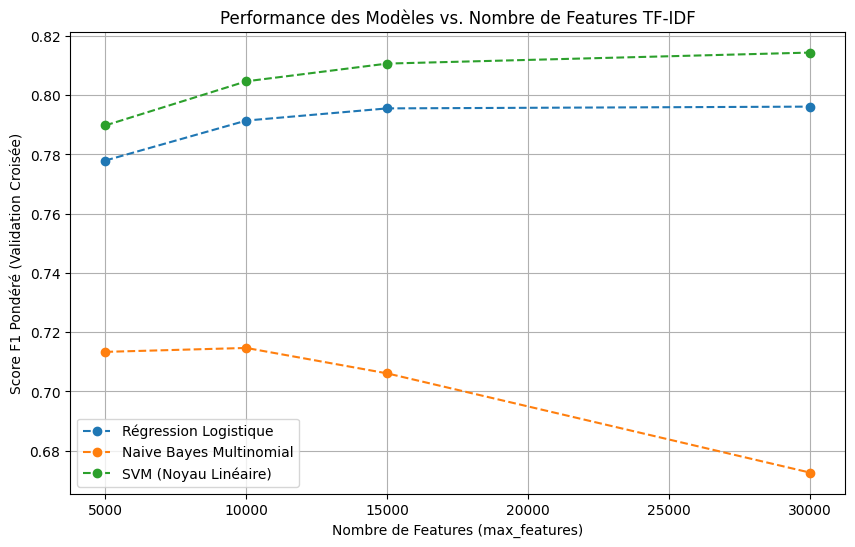

In [ ]:
# ====== 5. ÉVALUATION DES MODÈLES AVEC DIFFÉRENTES CONFIGURATIONS TF-IDF ======

# L'objectif ici est de voir comment la performance de chaque modèle varie
# en fonction du nombre de features (mots) retenus par le vectorizer TF-IDF.

models_to_evaluate = {
    "Régression Logistique": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes Multinomial": MultinomialNB(),
    "SVM (Noyau Linéaire)": SVC(kernel='linear', random_state=42)
}
max_features_options = [5000, 10000, 15000, 30000]

results = {}

if not df_fr.empty:
    for model_name, model in models_to_evaluate.items():
        print(f"\n--- Évaluation de : {model_name} ---")
        mean_scores = []
        for max_feat in max_features_options:
            # Vectorisation avec la configuration actuelle
            vectorizer = TfidfVectorizer(max_features=max_feat)
            X_train_tfidf = vectorizer.fit_transform(X_train)

            # Validation croisée sur 5 folds
            scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
            mean_scores.append(scores.mean())
            print(f"  Max features: {max_feat:<5} -> F1-Score pondéré moyen : {scores.mean():.4f}")

        results[model_name] = mean_scores

    # Visualisation des résultats de l'exploration
    plt.figure(figsize=(10, 6))
    for model_name, scores in results.items():
        plt.plot(max_features_options, scores, marker='o', linestyle='--', label=model_name)
    plt.xlabel("Nombre de Features (max_features)")
    plt.ylabel("Score F1 Pondéré (Validation Croisée)")
    plt.title("Performance des Modèles vs. Nombre de Features TF-IDF")
    plt.legend()
    plt.grid(True)
    plt.show()


--- Évaluation de : KNN ---
  Max features: 5000  -> F1-Score pondéré moyen : 0.5973
  Max features: 10000 -> F1-Score pondéré moyen : 0.5630
  Max features: 15000 -> F1-Score pondéré moyen : 0.5461
  Max features: 30000 -> F1-Score pondéré moyen : 0.4927

--- Évaluation de : Decision Tree ---
  Max features: 5000  -> F1-Score pondéré moyen : 0.6691
  Max features: 10000 -> F1-Score pondéré moyen : 0.6761
  Max features: 15000 -> F1-Score pondéré moyen : 0.6747
  Max features: 30000 -> F1-Score pondéré moyen : 0.6787


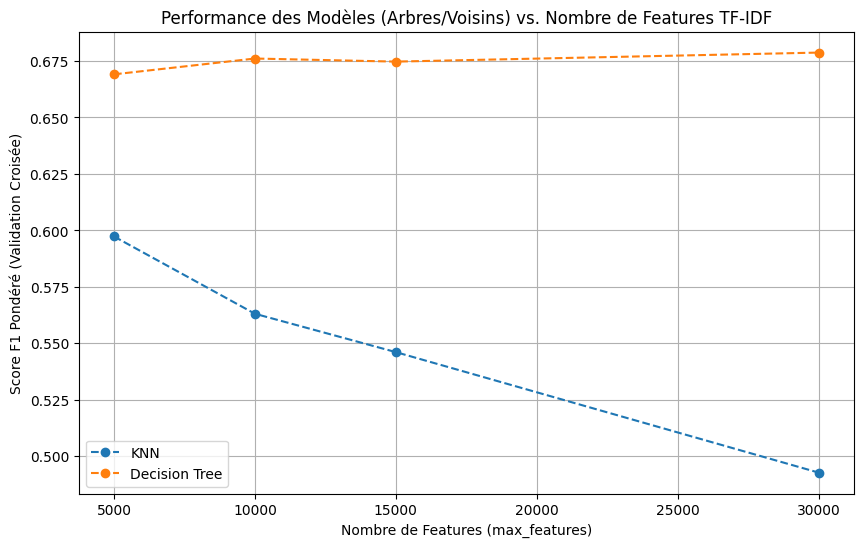

In [ ]:
# ====== 5bis. ÉVALUATION DE MODÈLES BASÉS SUR DES ARBRES ET VOISINS ======

models_to_evaluate_bis = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# On utilise les mêmes options de features pour pouvoir comparer
max_features_options = [5000, 10000, 15000, 30000]

results_bis = {}

# On vérifie l'existence de X_train, qui est toujours chargé,
# plutôt que df_fr qui peut ne pas être défini avec le chargement rapide.
if 'X_train' in locals() and not X_train.empty:
    for model_name, model in models_to_evaluate_bis.items():
        print(f"\n--- Évaluation de : {model_name} ---")
        mean_scores = []
        for max_feat in max_features_options:
            # Vectorisation avec la configuration actuelle
            vectorizer = TfidfVectorizer(max_features=max_feat)
            X_train_tfidf = vectorizer.fit_transform(X_train)

            # Validation croisée sur 5 folds
            scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
            mean_scores.append(scores.mean())
            print(f"  Max features: {max_feat:<5} -> F1-Score pondéré moyen : {scores.mean():.4f}")

        results_bis[model_name] = mean_scores

    # Visualisation des résultats de cette nouvelle exploration
    plt.figure(figsize=(10, 6))
    for model_name, scores in results_bis.items():
        plt.plot(max_features_options, scores, marker='o', linestyle='--', label=model_name)

    plt.xlabel("Nombre de Features (max_features)")
    plt.ylabel("Score F1 Pondéré (Validation Croisée)")
    plt.title("Performance des Modèles (Arbres/Voisins) vs. Nombre de Features TF-IDF")
    plt.legend()
    plt.grid(True)
    plt.show()


--- Évaluation de : XGBoost ---
  Max features: 5000  -> F1-Score pondéré moyen : 0.7863
  Max features: 10000 -> F1-Score pondéré moyen : 0.7958
  Max features: 15000 -> F1-Score pondéré moyen : 0.7991
  Max features: 30000 -> F1-Score pondéré moyen : 0.7982


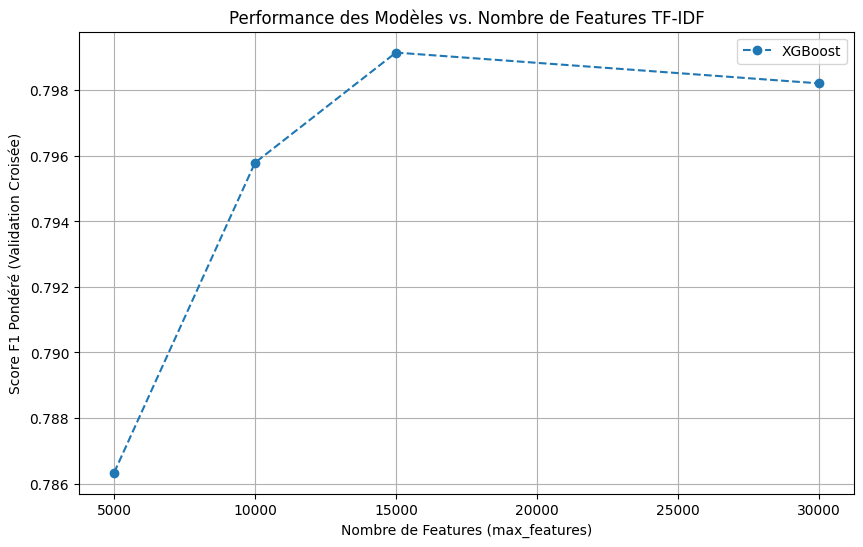

In [ ]:
# ====== 5ter. ÉVALUATION DE MODÈLES BASÉS SUR DES ARBRES ET VOISINS ======

models_to_evaluate_bis = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# On utilise les mêmes options de features pour pouvoir comparer
max_features_options = [5000, 10000, 15000, 30000]

results_bis = {}

# On vérifie l'existence de X_train, qui est toujours chargé,
# plutôt que df_fr qui peut ne pas être défini avec le chargement rapide.
if 'X_train' in locals() and not X_train.empty:
    for model_name, model in models_to_evaluate_bis.items():
        print(f"\n--- Évaluation de : {model_name} ---")
        mean_scores = []
        for max_feat in max_features_options:
            # Vectorisation avec la configuration actuelle
            vectorizer = TfidfVectorizer(max_features=max_feat)
            X_train_tfidf = vectorizer.fit_transform(X_train)

            # Validation croisée sur 5 folds
            scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
            mean_scores.append(scores.mean())
            print(f"  Max features: {max_feat:<5} -> F1-Score pondéré moyen : {scores.mean():.4f}")

        results_bis[model_name] = mean_scores

    # Visualisation des résultats de cette nouvelle exploration
    plt.figure(figsize=(10, 6))
    for model_name, scores in results_bis.items():
        plt.plot(max_features_options, scores, marker='o', linestyle='--', label=model_name)

    plt.xlabel("Nombre de Features (max_features)")
    plt.ylabel("Score F1 Pondéré (Validation Croisée)")
    plt.title("Performance des Modèles vs. Nombre de Features TF-IDF")
    plt.legend()
    plt.grid(True)
    plt.show()

**Entraînement et Évaluation du Modèle Final**

Forts de notre analyse précédente, nous sélectionnons le **SVM avec un noyau linéaire et un vocabulaire de 30 000 mots** comme notre modèle de référence.

Nous allons maintenant suivre la procédure standard :
1.  **Entraîner le vectoriseur TF-IDF** sur *l'intégralité* de l'ensemble d'entraînement (`X_train`).
2.  Utiliser ce vectoriseur pour **transformer** à la fois `X_train` et `X_test`.
3.  **Entraîner le modèle SVM** sur les données d'entraînement vectorisées.
4.  **Évaluer sa performance** finale sur l'ensemble de test, qu'il n'a jamais vu auparavant.

In [ ]:
# ====== 6. ENTRAÎNEMENT ET ÉVALUATION DU MODÈLE FINAL ======

# D'après l'analyse du graphique, le modèle SVM avec un noyau linéaire et
# 30 000 features est le plus performant.
# Nous allons maintenant l'entraîner sur l'intégralité des données
# d'entraînement et l'évaluer sur l'ensemble de test.

print("--- Entraînement du modèle final : SVM avec 30,000 features ---")

# 1. Vectorisation des données avec la configuration choisie
print("\nÉtape 1 : Vectorisation des données d'entraînement et de test...")
final_vectorizer = TfidfVectorizer(max_features=30000)

# Apprentissage du vocabulaire sur X_train et transformation
X_train_final_tfidf = final_vectorizer.fit_transform(X_train)

# Transformation de X_test avec le vocabulaire appris
X_test_final_tfidf = final_vectorizer.transform(X_test)

print(f"Dimension de la matrice TF-IDF d'entraînement : {X_train_final_tfidf.shape}")
print(f"Dimension de la matrice TF-IDF de test : {X_test_final_tfidf.shape}")


# 2. Entraînement du modèle sur l'intégralité du jeu d'entraînement
print("\nÉtape 2 : Entraînement du modèle SVM...")
# On instancie le modèle final
final_model = SVC(kernel='linear', random_state=42)

# Entraînement
final_model.fit(X_train_final_tfidf, y_train)
print("Entraînement terminé.")

# 3. Prédiction et évaluation sur le jeu de test
print("\nÉtape 3 : Évaluation sur l'ensemble de test...")
y_pred_final = final_model.predict(X_test_final_tfidf)

# Récupération des noms de classe originaux (qui sont des nombres)
original_class_names = label_encoder.inverse_transform(final_model.classes_)

# Conversion des noms de classe en chaînes de caractères (str)
class_names_as_strings = [str(name) for name in original_class_names]

# Affichage du rapport de classification final avec les noms de classe en format texte
print("\n" + "="*50)
print("   RAPPORT DE CLASSIFICATION FINAL SUR LES DONNÉES DE TEST   ")
print("="*50)
print(classification_report(y_test, y_pred_final, target_names=class_names_as_strings, digits=4))

--- Entraînement du modèle final : SVM avec 30,000 features ---

Étape 1 : Vectorisation des données d'entraînement et de test...
Dimension de la matrice TF-IDF d'entraînement : (56375, 30000)
Dimension de la matrice TF-IDF de test : (14094, 30000)

Étape 2 : Entraînement du modèle SVM...
Entraînement terminé.

Étape 3 : Évaluation sur l'ensemble de test...

   RAPPORT DE CLASSIFICATION FINAL SUR LES DONNÉES DE TEST   
              precision    recall  f1-score   support

          10     0.4112    0.4064    0.4088       342
          40     0.7864    0.6353    0.7028       255
          50     0.8464    0.8889    0.8671       279
          60     0.9922    0.9007    0.9442       141
        1140     0.7654    0.7835    0.7743       254
        1160     0.9448    0.9299    0.9373       442
        1180     0.7895    0.4945    0.6081        91
        1280     0.6600    0.6287    0.6440       738
        1281     0.6995    0.4581    0.5536       310
        1300     0.8140    0.9420   


--- Génération de la Matrice de Confusion pour le modèle de base (Étape 6) ---


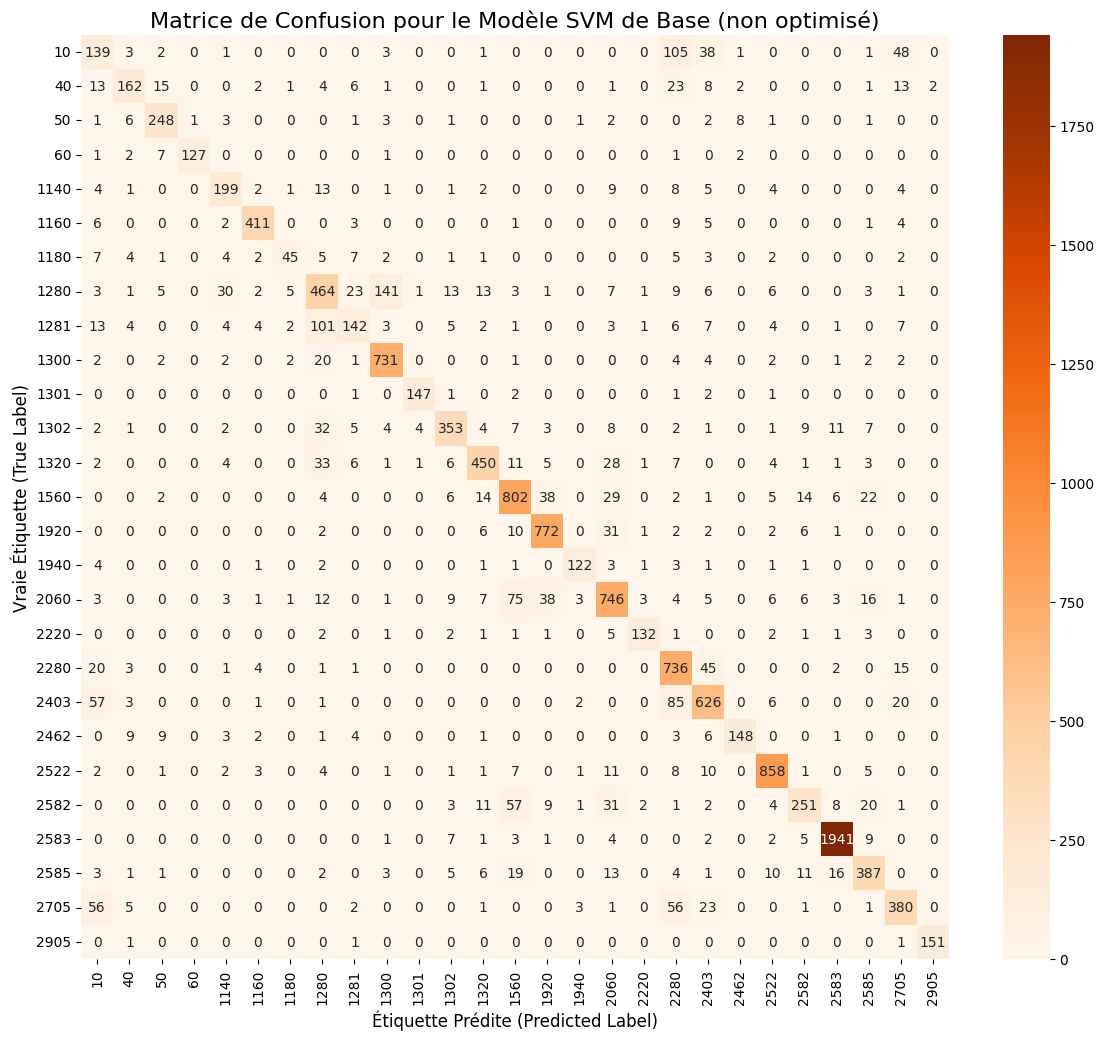

In [ ]:
# ====== 6bis. VISUALISATION DE LA MATRICE DE CONFUSION ======

# Alors que le rapport de classification nous donne des métriques de performance
# (précision, rappel, F1-score), la matrice de confusion nous offre une vue
# plus détaillée. Elle nous montre exactement quelles classes le modèle a tendance
# à confondre entre elles.
#
# Comment lire la matrice :
# - L'axe Y représente les vraies classes.
# - L'axe X représente les classes prédites par le modèle.
# - La diagonale (de haut à gauche à bas à droite) contient les prédictions correctes.
# - Toutes les autres cellules hors de la diagonale représentent des erreurs.

print("\n--- Génération de la Matrice de Confusion pour le modèle de base (Étape 6) ---")

# 1. Calcul de la matrice de confusion
# On utilise les vraies étiquettes du jeu de test (y_test) et les prédictions
# du modèle de base (y_pred_final).
cm_base = confusion_matrix(y_test, y_pred_final)

# 2. Visualisation de la matrice sous forme de heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_base,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=class_names_as_strings,
    yticklabels=class_names_as_strings
)

plt.title("Matrice de Confusion pour le Modèle SVM de Base (non optimisé)", fontsize=16)
plt.ylabel("Vraie Étiquette (True Label)", fontsize=12)
plt.xlabel("Étiquette Prédite (Predicted Label)", fontsize=12)
plt.show()


--- Étape 6bis : Validation croisée du modèle final (SVM avec 30,000 features) ---

Lancement de la validation croisée (5 folds)...
Validation croisée terminée.

Scores F1 pondérés pour chaque fold : [0.81281897 0.8143243  0.81889687 0.81688467 0.81331855]
Score F1 moyen : 0.8152
Écart-type des scores : 0.0023

Création du graphique de distribution des scores...


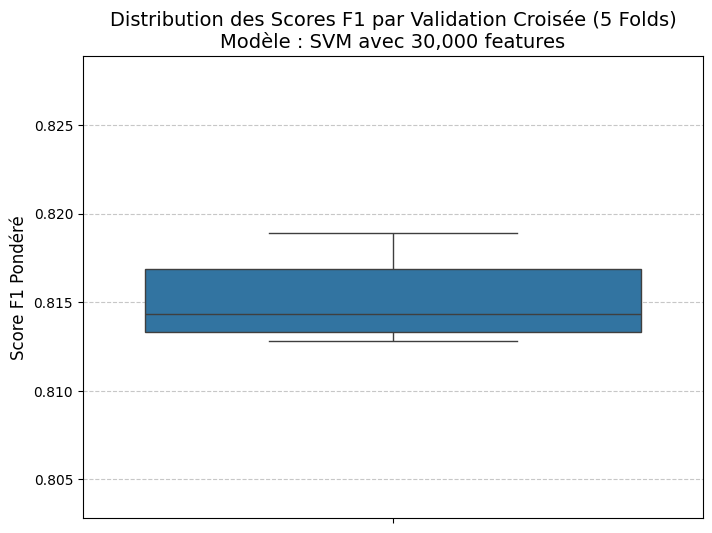

In [ ]:
# ====== 6ter. VISUALISATION DE LA STABILITÉ DU MODÈLE PAR VALIDATION CROISÉE ======

# L'évaluation sur un unique jeu de test (étape 6) nous a donné un score final.
# Cependant, ce score peut dépendre de la séparation initiale
# des données. La validation croisée permet de palier ce problème en entraînant et
# évaluant le modèle sur plusieurs découpages différents des données.
# Cela nous donne une meilleure idée de la performance moyenne attendue du modèle
# et de sa stabilité (faible variance entre les scores).

print("\n--- Étape 6bis : Validation croisée du modèle final (SVM avec 30,000 features) ---")

# 1. Création d'un Pipeline
# Un pipeline est la méthode la plus propre et la plus sûre pour la validation croisée.
# Il garantit que le TfidfVectorizer est ajusté uniquement sur la partie "entraînement"
# de chaque fold, évitant ainsi toute fuite de données.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=30000)),
    ('svm', SVC(kernel='linear', random_state=42))
])

# 2. Définition de la stratégie de validation croisée
# StratifiedKFold s'assure que la proportion des classes est la même dans chaque fold,
# ce qui est crucial pour les problèmes de classification.
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Exécution de la validation croisée
# Nous utilisons les données d'entraînement complètes (X_train, y_train).
print("\nLancement de la validation croisée (5 folds)...")
scores = cross_val_score(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1 # Utilise tous les coeurs de CPU disponibles
)
print("Validation croisée terminée.")

# 4. Affichage des résultats numériques
print(f"\nScores F1 pondérés pour chaque fold : {scores}")
print(f"Score F1 moyen : {scores.mean():.4f}")
print(f"Écart-type des scores : {scores.std():.4f}")


# 5. Création du graphique (Box Plot)
print("\nCréation du graphique de distribution des scores...")
plt.figure(figsize=(8, 6))
sns.boxplot(y=scores)
plt.title("Distribution des Scores F1 par Validation Croisée (5 Folds)\nModèle : SVM avec 30,000 features", fontsize=14)
plt.ylabel("Score F1 Pondéré", fontsize=12)
plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Deux scores de performance ont été calculés pour évaluer notre modèle. Leur comparaison permet de statuer sur sa fiabilité.

Score initial (Étape 6) : 0.8260. Ce résultat provient d'une évaluation unique (découpage 80/20). Bien que positif, il constitue une mesure ponctuelle sensible à la répartition aléatoire des données de test. Il pouvait donc s'agir d'une estimation légèrement optimiste.

Score consolidé par validation croisée (Étape 6ter) : 0.8152. Ce score est la moyenne obtenue sur cinq cycles d'entraînement/test distincts. En moyennant les performances, nous neutralisons l'impact de "chance" d'un découpage favorable. Ce résultat offre une vision beaucoup plus robuste et stable de la capacité de généralisation du modèle.

Interprétation

La différence observée entre les deux scores ne signifie pas une baisse de qualité du modèle. Elle valide notre démarche de fiabilisation. Le score de 0.8260 était une première mesure prometteuse, tandis que le score de 0.8152 doit être considéré comme l'indicateur le plus juste et le plus représentatif de la performance que nous pouvons attendre du modèle en conditions réelles.

**Optimisation des Hyperparamètres (GridSearchCV)**

Même si notre modèle SVM est performant, il est possible de l'améliorer en ajustant ses hyperparamètres. Nous nous concentrons sur le paramètre `C`, qui contrôle la régularisation :
- Un **`C` faible** favorise une marge de séparation plus grande, même si cela implique de mal classer quelques points d'entraînement. Cela rend le modèle plus simple et moins sujet au surapprentissage.
- Un **`C` élevé** cherche à classer correctement chaque point d'entraînement, ce qui peut mener à une marge plus petite et un modèle plus complexe.

Nous utilisons `GridSearchCV` pour tester automatiquement plusieurs valeurs de `C` et déterminer la meilleure grâce à une validation croisée.

In [ ]:
# ====== 7. OPTIMISATION DES HYPERPARAMÈTRES AVEC GRIDSEARCHCV ======

print("\n--- Étape 7 : Optimisation des hyperparamètres du SVM avec GridSearchCV ---")

# 1. Définition de la grille de paramètres à tester
# Nous testons des valeurs sur une échelle logarithmique, ce qui est courant pour le paramètre C.
param_grid = {
    'C': [0.1, 1, 10, 100]
}

# 2. Initialisation de GridSearchCV
# Le vectorizer et les données (X_train_final_tfidf) sont les mêmes qu'à l'étape 6.
# n_jobs=-1 utilise tous les coeurs de CPU disponibles pour accélérer la recherche.
# verbose=3 affiche des logs détaillés sur la progression.
grid_search = GridSearchCV(
    estimator=SVC(kernel='linear', random_state=42),
    param_grid=param_grid,
    cv=5, # Validation croisée sur 5 folds
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=3
)

# 3. Lancement de la recherche d'hyperparamètres
print("\nLancement du GridSearchCV... (cela peut prendre du temps)")
grid_search.fit(X_train_final_tfidf, y_train)

# 4. Affichage des résultats de la recherche
print("\n--- Résultats du GridSearchCV ---")
print(f"Meilleur paramètre 'C' trouvé : {grid_search.best_params_['C']}")
print(f"Meilleur score F1 pondéré (obtenu par validation croisée) : {grid_search.best_score_:.4f}")

# 5. Évaluation finale du modèle optimisé sur le jeu de test
print("\n--- Évaluation du modèle optimisé sur les données de test ---")

best_svm_tuned = grid_search.best_estimator_
y_pred_tuned = best_svm_tuned.predict(X_test_final_tfidf)

original_class_names = label_encoder.inverse_transform(best_svm_tuned.classes_)
class_names_as_strings = [str(name) for name in original_class_names]

# Affichage du rapport de classification final pour le modèle optimisé
print("\n" + "="*50)
print("   RAPPORT DE CLASSIFICATION FINAL (MODÈLE OPTIMISÉ)   ")
print("="*50)
print(classification_report(y_test, y_pred_tuned, target_names=class_names_as_strings, digits=4))

# Ce rapport peut être comparé à celui de l'étape 6 pour voir si
# l'optimisation de l'hyperparamètre 'C' a apporté une amélioration sur
# les données de test.


--- Étape 7 : Optimisation des hyperparamètres du SVM avec GridSearchCV ---

Lancement du GridSearchCV... (cela peut prendre du temps)
Fitting 5 folds for each of 4 candidates, totalling 20 fits

--- Résultats du GridSearchCV ---
Meilleur paramètre 'C' trouvé : 1
Meilleur score F1 pondéré (obtenu par validation croisée) : 0.8143

--- Évaluation du modèle optimisé sur les données de test ---

   RAPPORT DE CLASSIFICATION FINAL (MODÈLE OPTIMISÉ)   
              precision    recall  f1-score   support

          10     0.4112    0.4064    0.4088       342
          40     0.7864    0.6353    0.7028       255
          50     0.8464    0.8889    0.8671       279
          60     0.9922    0.9007    0.9442       141
        1140     0.7654    0.7835    0.7743       254
        1160     0.9448    0.9299    0.9373       442
        1180     0.7895    0.4945    0.6081        91
        1280     0.6600    0.6287    0.6440       738
        1281     0.6995    0.4581    0.5536       310
       

**Conclusion de l'Optimisation**

Les résultats de `GridSearchCV` indiquent que `C=1` est la valeur optimale parmi celles testées. Il s'agit de la valeur par défaut pour `SVC` dans scikit-learn.

En comparant le rapport de classification final du modèle optimisé avec celui du modèle de base (étape 6), nous constatons que les **performances sont identiques**. Cela signifie que le paramètre `C` par défaut était déjà très bien adapté à notre problème, et que des ajustements supplémentaires sur ce paramètre n'apportent pas de gain significatif.


--- Étape 7bis : Génération de la Matrice de Confusion pour le modèle optimisé ---


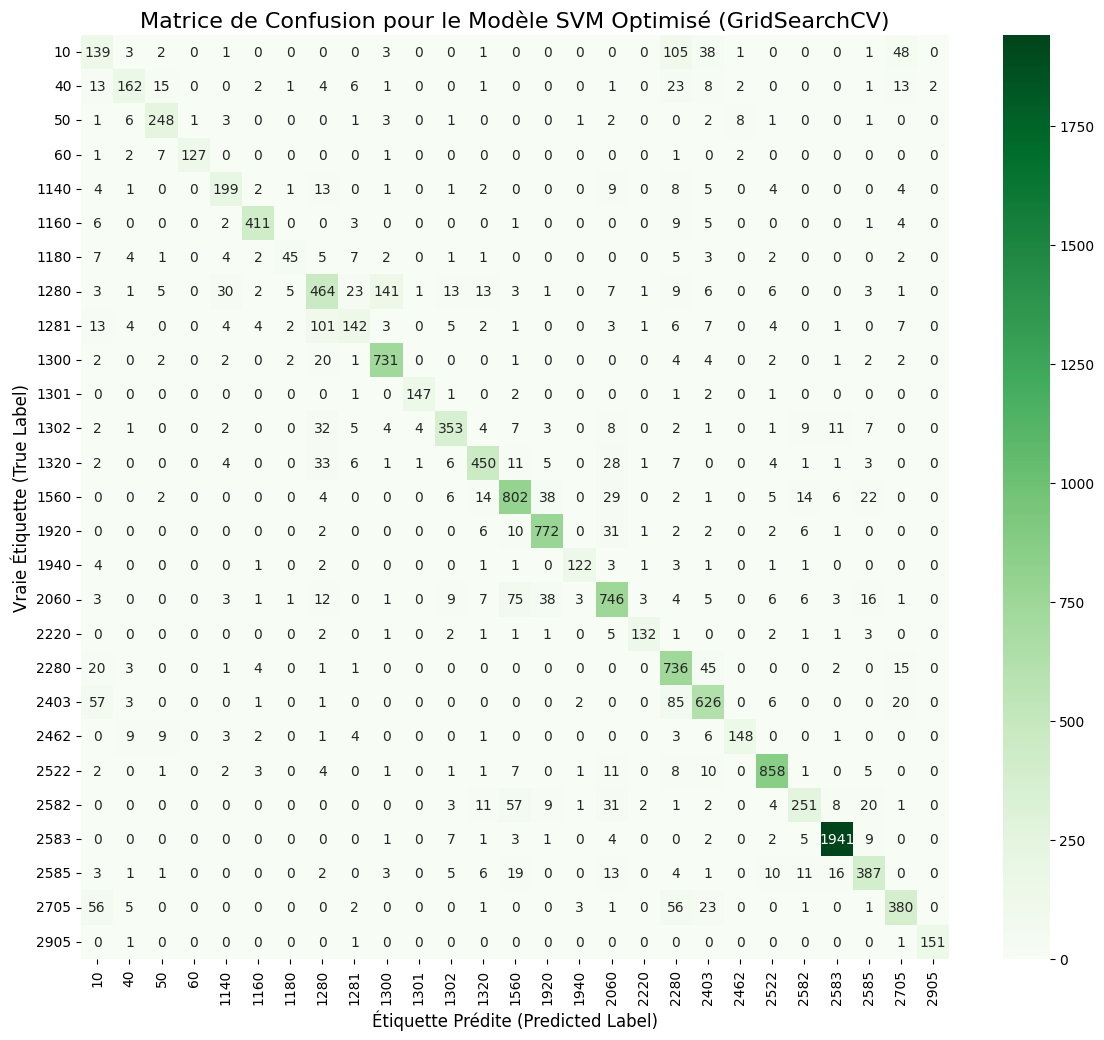

In [ ]:
# ====== 7bis. MATRICE DE CONFUSION POUR LE MODÈLE OPTIMISÉ ======

# Après avoir optimisé le modèle avec GridSearchCV, nous générons une nouvelle
# matrice de confusion.
# L'objectif est de voir si le réglage de l'hyperparamètre 'C' a permis
# de réduire les erreurs de classification entre les classes.

print("\n--- Étape 7bis : Génération de la Matrice de Confusion pour le modèle optimisé ---")

# 1. Calcul de la matrice de confusion
# On utilise les vraies étiquettes (y_test) et les prédictions du modèle
# optimisé par GridSearchCV (y_pred_tuned).
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# 2. Visualisation de la matrice sous forme de heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_tuned,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names_as_strings,
    yticklabels=class_names_as_strings
)

plt.title("Matrice de Confusion pour le Modèle SVM Optimisé (GridSearchCV)", fontsize=16)
plt.ylabel("Vraie Étiquette (True Label)", fontsize=12)
plt.xlabel("Étiquette Prédite (Predicted Label)", fontsize=12)
plt.show()

**Exploration de Modèles de Deep Learning**

Après avoir optimisé notre approche classique, nous nous tournons vers des architectures de Deep Learning, qui représentent l'état de l'art en NLP.

> **Note sur les ressources :** L'entraînement de ces modèles est très coûteux en calculs. Pour une exécution rapide, nous travaillerons sur un **sous-ensemble de 20 000 exemples** et limiterons l'entraînement à **quelques époques**. L'objectif est d'obtenir une première estimation de leur potentiel.

**Modèle Transformer : CamemBERT**

**CamemBERT** est un modèle de type Transformer pré-entraîné sur une très grande quantité de texte français. Contrairement à TF-IDF, il génère des représentations vectorielles (*embeddings*) qui capturent le sens des mots en fonction de leur contexte, ce qui le rend particulièrement puissant.

**Modèle Convolutif (CNN)**

Nous testerons également un **réseau de neurones convolutif (CNN)**, une approche plus légère. La préparation des données est similaire à celle des Transformers :
1.  **Tokenisation** : Chaque mot est associé à un entier.
2.  **Mise en séquence et Padding** : Les textes sont transformés en séquences de longueur fixe.
3.  **Embedding** : Le modèle apprend des vecteurs pour chaque mot.
4.  **Convolution** : Des filtres balaient le texte pour détecter des motifs locaux (similaires aux n-grammes), qui sont ensuite utilisés pour la classification.


In [ ]:
# --- 8.1. Installation et Importations nécessaires ---
!pip install transformers[torch] -q

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Importations depuis transformers
from transformers import CamembertTokenizer, CamembertForSequenceClassification, get_linear_schedule_with_warmup
# Importation de l'optimiseur depuis torch
from torch.optim import AdamW

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00


In [ ]:
# --- 8.2. Vérification de la disponibilité du GPU ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU détecté : {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Aucun GPU détecté, utilisation du CPU.')

GPU détecté : Tesla T4


In [ ]:
print("--- Étape 8 : Entraînement et Évaluation d'un modèle CamemBERT ---")

# --- 8.3. Préparation des données ---
# On réduit la taille pour un entraînement plus rapide dans ce notebook
X_train_bert, _, y_train_bert, _ = train_test_split(
    X_train, y_train, train_size=20000, random_state=42, stratify=y_train
)

# Chargement du tokenizer CamemBERT
print("\nChargement du tokenizer CamemBERT...")
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Tokenisation des textes (entraînement et test)
def tokenize_data(texts, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

print("Tokenisation des données d'entraînement...")
X_train_ids, X_train_masks = tokenize_data(X_train_bert.to_list())
y_train_tensor = torch.tensor(y_train_bert.to_list())

print("Tokenisation des données de test...")
X_test_ids, X_test_masks = tokenize_data(X_test.to_list())
y_test_tensor = torch.tensor(y_test.to_list())


# Création des DataLoaders
batch_size = 16

train_data = TensorDataset(X_train_ids, X_train_masks, y_train_tensor)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test_ids, X_test_masks, y_test_tensor)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# --- 8.4. Chargement et Configuration du Modèle ---
print("\nChargement du modèle CamemBERT pré-entraîné...")
model_bert = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels=len(label_encoder.classes_),
    output_attentions=False,
    output_hidden_states=False,
)
model_bert.to(device)

# --- 8.5. Configuration de l'entraînement ---
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
epochs = 1
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# --- 8.6. Boucle d'entraînement ---
print("\nLancement de l'entraînement du modèle BERT...")
for epoch_i in range(0, epochs):
    print(f'\n======== Époque {epoch_i + 1} / {epochs} ========')
    total_train_loss = 0
    model_bert.train()

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step} sur {len(train_dataloader)}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model_bert.zero_grad()
        result = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = result.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bert.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"\n  Perte moyenne d'entraînement: {avg_train_loss:.4f}")

print("\nEntraînement terminé.")


# --- 8.7. Évaluation du modèle BERT ---
print("\n--- Évaluation du modèle BERT sur les données de test ---")
model_bert.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model_bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Aplatir les résultats
flat_predictions = np.concatenate(predictions, axis=0)
y_pred_bert = np.argmax(flat_predictions, axis=1).flatten()
y_true_bert = np.concatenate(true_labels, axis=0)

# --- 8.7. Évaluation du modèle BERT ---
# ... (code d'évaluation) ...

# Affichage du rapport de classification
print("\n" + "="*50)
print("   RAPPORT DE CLASSIFICATION (MODÈLE CamemBERT)   ")
print("="*50)

class_names_as_strings = [str(name) for name in label_encoder.classes_]
print(classification_report(y_true_bert, y_pred_bert, target_names=class_names_as_strings, digits=4))

--- Étape 8 : Entraînement et Évaluation d'un modèle CamemBERT ---

Chargement du tokenizer CamemBERT...
Tokenisation des données d'entraînement...
Tokenisation des données de test...

Chargement du modèle CamemBERT pré-entraîné...


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Lancement de l'entraînement du modèle BERT...

======== Époque 1 / 1 ========
  Batch 50 sur 1250.
  Batch 100 sur 1250.
  Batch 150 sur 1250.
  Batch 200 sur 1250.
  Batch 250 sur 1250.
  Batch 300 sur 1250.
  Batch 350 sur 1250.
  Batch 400 sur 1250.
  Batch 450 sur 1250.
  Batch 500 sur 1250.
  Batch 550 sur 1250.
  Batch 600 sur 1250.
  Batch 650 sur 1250.
  Batch 700 sur 1250.
  Batch 750 sur 1250.
  Batch 800 sur 1250.
  Batch 850 sur 1250.
  Batch 900 sur 1250.
  Batch 950 sur 1250.
  Batch 1000 sur 1250.
  Batch 1050 sur 1250.
  Batch 1100 sur 1250.
  Batch 1150 sur 1250.
  Batch 1200 sur 1250.

  Perte moyenne d'entraînement: 2.0206

Entraînement terminé.

--- Évaluation du modèle BERT sur les données de test ---

   RAPPORT DE CLASSIFICATION (MODÈLE CamemBERT)   
              precision    recall  f1-score   support

          10     0.0000    0.0000    0.0000       342
          40     0.0000    0.0000    0.0000       255
          50     0.4140    0.7849    0.5421       27

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Étape 8bis : Génération de la Matrice de Confusion pour le modèle CamemBERT ---


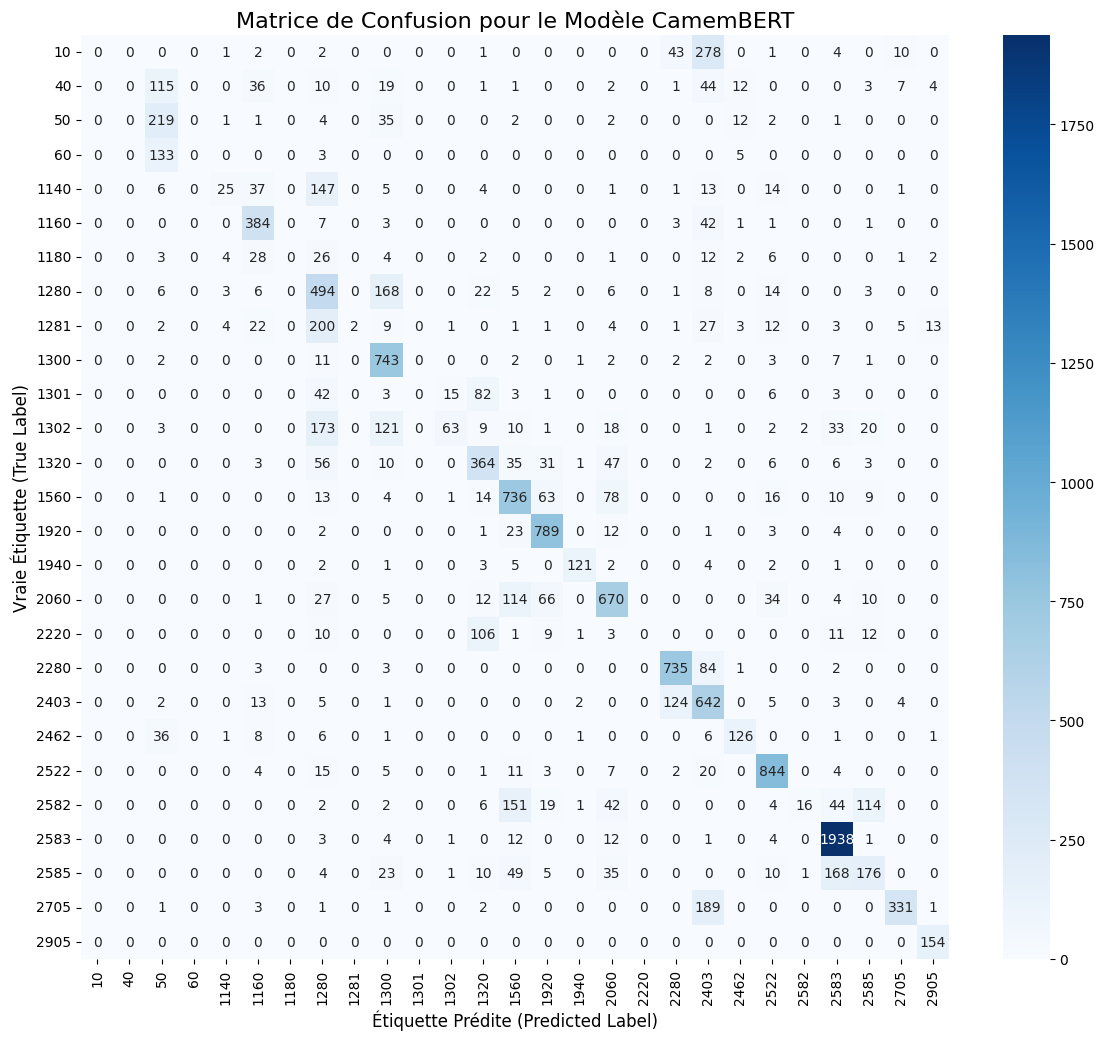

In [ ]:
# ====== 8bis. MATRICE DE CONFUSION POUR LE MODÈLE CamemBERT ======

# Comme pour les modèles précédents, nous visualisons la matrice de confusion
# pour analyser en détail les erreurs de classification du modèle CamemBERT.

print("\n--- Étape 8bis : Génération de la Matrice de Confusion pour le modèle CamemBERT ---")

# 1. Calcul de la matrice de confusion
# On utilise les vraies étiquettes (y_true_bert) et les prédictions du modèle (y_pred_bert)
# calculées à l'étape précédente.
cm_bert = confusion_matrix(y_true_bert, y_pred_bert)

# 2. Visualisation de la matrice sous forme de heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names_as_strings,
    yticklabels=class_names_as_strings
)

plt.title("Matrice de Confusion pour le Modèle CamemBERT", fontsize=16)
plt.ylabel("Vraie Étiquette (True Label)", fontsize=12)
plt.xlabel("Étiquette Prédite (Predicted Label)", fontsize=12)
plt.show()

In [ ]:
# ====== 9. ENTRAÎNEMENT ET ÉVALUATION D'UN MODÈLE CNN ======

print("--- Étape 9 : Préparation des données et entraînement du CNN ---")


# --- 9.1. Préparation et Tokenisation des données ---

# Définition des paramètres pour la tokenisation et le padding
# On garde 30 000 mots comme pour nos meilleurs modèles précédents
MAX_WORDS = 30000
MAX_LENGTH = 256 # Longueur maximale des séquences de texte

# Création et ajustement du tokenizer sur les données d'entraînement
print("\nÉtape 9.1.1 : Tokenisation des textes...")
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

# Conversion des textes en séquences d'entiers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding des séquences pour avoir une longueur uniforme
print("Étape 9.1.2 : Padding des séquences...")
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH)

print(f"Dimension des données d'entraînement paddées : {X_train_pad.shape}")
print(f"Dimension des données de test paddées : {X_test_pad.shape}")


# --- 9.2. Création du modèle CNN ---

print("\nÉtape 9.2 : Construction du modèle CNN...")
embedding_dim = 128 # Taille des vecteurs d'embedding (représentation dense des mots)
num_classes = len(label_encoder.classes_)

cnn_model = Sequential([
    # Couche d'Embedding : Apprend une représentation vectorielle pour chaque mot
    Embedding(input_dim=MAX_WORDS, output_dim=embedding_dim, input_length=MAX_LENGTH),

    # Couche de Convolution : Détecte les motifs locaux (comme des n-grammes)
    Conv1D(filters=64, kernel_size=5, activation="relu"),

    # Couche de Pooling : Réduit la dimensionnalité et garde les caractéristiques importantes
    MaxPooling1D(pool_size=2),

    # Aplatit les données pour les passer à une couche dense
    Flatten(),

    # Couche dense classique pour la classification
    Dense(64, activation="relu"),

    # Couche de sortie avec une fonction d'activation softmax pour la classification multi-classes
    Dense(num_classes, activation="softmax")
])

# Compilation du modèle
print("Étape 9.2.1 : Compilation du modèle...")
cnn_model.compile(
    loss="sparse_categorical_crossentropy", # Adapté pour des labels entiers
    optimizer="adam",
    metrics=["accuracy"]
)

cnn_model.summary()


# --- 9.3. Entraînement du modèle CNN ---
print("\nÉtape 9.3 : Lancement de l'entraînement...")

# Entraînement sur 5 époques avec une taille de batch de 32
# Utilisation de 10% des données d'entraînement pour la validation à chaque époque
history = cnn_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.1 # Utilise une partie du training set pour la validation
)


# --- 9.4. Évaluation finale du modèle CNN ---
print("\nÉtape 9.4 : Évaluation du modèle sur les données de test...")

# Prédictions sur le jeu de test
y_pred_proba_cnn = cnn_model.predict(X_test_pad)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# Affichage du rapport de classification
print("\n" + "="*50)
print("   RAPPORT DE CLASSIFICATION (MODÈLE CNN)   ")
print("="*50)
class_names_as_strings = [str(name) for name in label_encoder.classes_]

print(classification_report(y_test, y_pred_cnn, target_names=class_names_as_strings, digits=4))

--- Étape 9 : Préparation des données et entraînement du CNN ---

Étape 9.1.1 : Tokenisation des textes...
Étape 9.1.2 : Padding des séquences...
Dimension des données d'entraînement paddées : (56375, 256)
Dimension des données de test paddées : (14094, 256)

Étape 9.2 : Construction du modèle CNN...
Étape 9.2.1 : Compilation du modèle...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Étape 9.3 : Lancement de l'entraînement...
Epoch 1/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4753 - loss: 1.7910 - val_accuracy: 0.7659 - val_loss: 0.8228
Epoch 2/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8410 - loss: 0.5202 - val_accuracy: 0.7781 - val_loss: 0.8002
Epoch 3/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9128 - loss: 0.2726 - val_accuracy: 0.7790 - val_loss: 0.9331
Epoch 4/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9506 - loss: 0.1605 - val_accuracy: 0.7794 - val_loss: 1.0954
Epoch 5/5
1586/1586 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9710 - loss: 0.0991 - val_accuracy: 0.7703 - val_loss: 1.3315

Étape 9.4 : Évaluation du modèle sur les données de test...
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

   RAPPORT DE CLASSIFICATION (MODÈLE CNN)   
              precision    recall  f1-score   support

          10     0.3735    0.4532    0.4095       342
          40     0.4009    0.6980    0.5093       25


--- Génération de la Matrice de Confusion pour le modèle CNN ---


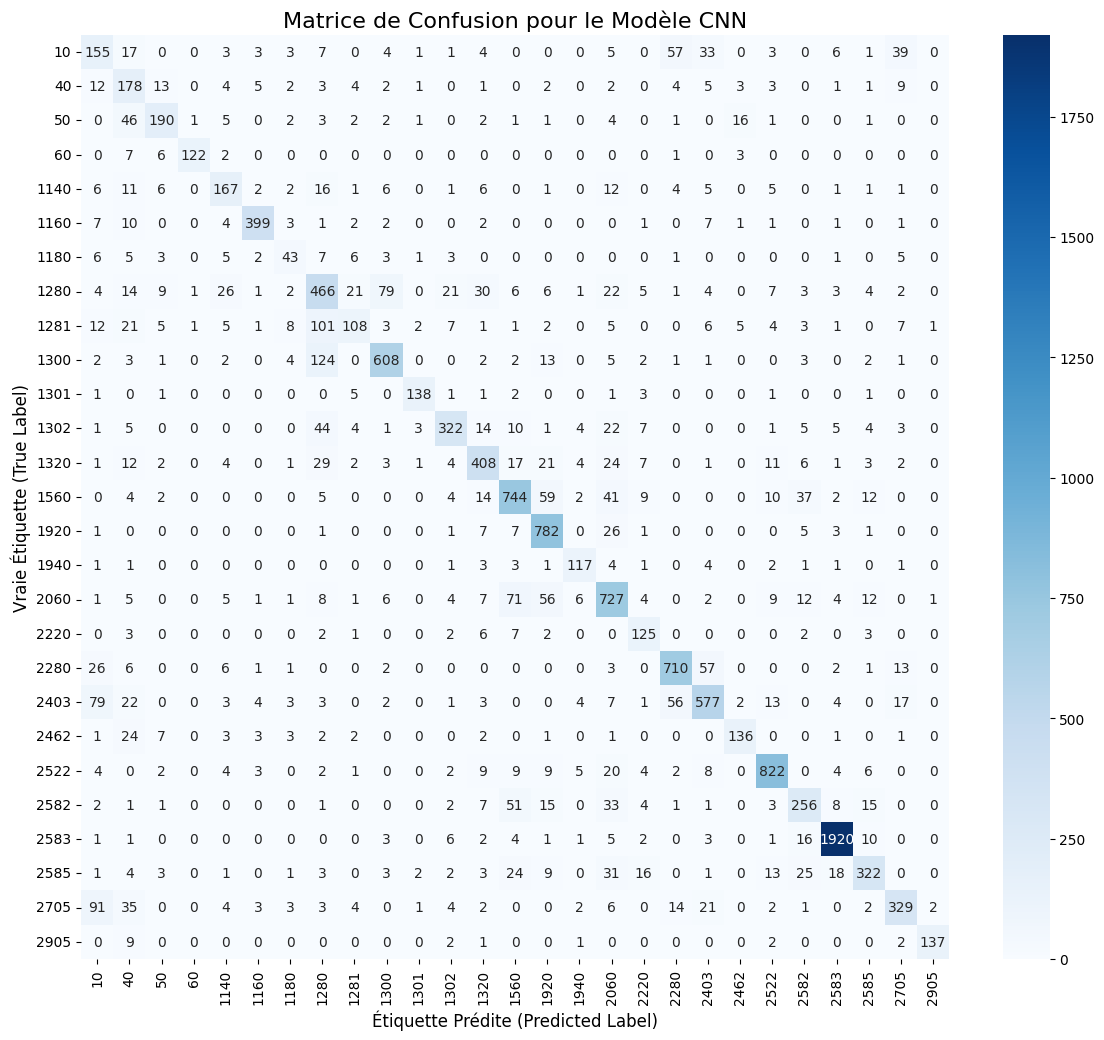

In [ ]:
# ====== 9bis. VISUALISATION DE LA MATRICE DE CONFUSION (CNN) ======

print("\n--- Génération de la Matrice de Confusion pour le modèle CNN ---")

# 1. Calcul de la matrice de confusion
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# 2. Visualisation de la matrice sous forme de heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt='d', # Format des annotations (entiers)
    cmap='Blues',
    xticklabels=class_names_as_strings,
    yticklabels=class_names_as_strings
)

plt.title("Matrice de Confusion pour le Modèle CNN", fontsize=16)
plt.ylabel("Vraie Étiquette (True Label)", fontsize=12)
plt.xlabel("Étiquette Prédite (Predicted Label)", fontsize=12)
plt.show()

**Synthèse et Conclusion Générale**

Ce notebook nous a permis d'explorer un pipeline complet de classification de texte, des modèles classiques aux approches de Deep Learning.

**Synthèse des performances :**
1.  **Modèle le plus performant (classique) :** Le **SVM à noyau linéaire** avec un vectoriseur TF-IDF sur 30 000 features s'est avéré être le plus robuste et le plus performant, atteignant un **F1-score pondéré d'environ 0.826**. L'optimisation de son hyperparamètre `C` n'a pas apporté d'amélioration notable.

2.  **Modèles Deep Learning (exploration) :**
    - Le **CNN**, après 5 époques, a atteint un **F1-score de 0.781**. C'est un résultat très prometteur qui pourrait certainement être amélioré avec plus de données et un entraînement plus long.
    - **CamemBERT**, même entraîné sur une seule époque et un sous-ensemble de données, montre un potentiel intéressant mais souffre de sous-entraînement, avec un F1-score de **0.626**.

**Conclusion :**
Pour une solution efficace et équilibrée en termes de performance et de coût de calcul, le **SVM linéaire reste le choix le plus pragmatique**. Cependant, les modèles de Deep Learning, en particulier le CNN, montrent un fort potentiel et pourraient surpasser le SVM avec un entraînement plus approfondi et davantage de données.